# Init and cuts definition

In [1]:
!pip install -I git+https://github.com/oksuzian/mu2etools.git
from mu2etools import utils, cuts

  Cloning https://github.com/oksuzian/mu2etools.git to /tmp/pip-req-build-l_sg0d4y
  Running command git clone --filter=blob:none --quiet https://github.com/oksuzian/mu2etools.git /tmp/pip-req-build-l_sg0d4y
  Resolved https://github.com/oksuzian/mu2etools.git to commit 1b8a2b88b5ce01e074aa5e1b62ecc36c5bfa5dfe
  Preparing metadata (setup.py) ... done
  Created wheel for mu2etools: filename=mu2etools-0.0.1-py3-none-any.whl size=5980 sha256=936b24789ddab50c40cf2b7dda3eb34696efab660a53786597ab3691b389124a
  Stored in directory: /tmp/pip-ephem-wheel-cache-u5fu_v2x/wheels/6c/b7/6f/70403eaed7bd451265390fc7caae8216d27a85d3bd1e77b7a8
Successfully built mu2etools


In [4]:
import hist
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import uproot
#rootCRY5lo='root://fndca1.fnal.gov/pnfs/fnal.gov/usr/mu2e/tape/usr-nts/nts/oksuzian/CosmicCRYloOnSpillSignal/MDC2020r_perfect_v1_0_trkana_v02_01_00/tka/38/4e/nts.oksuzian.CosmicCRYloOnSpillSignal.MDC2020r_perfect_v1_0_trkana_v02_01_00.002701_00000002.tka'
#rootCRY5hi='root://fndca1.fnal.gov/pnfs/fnal.gov/usr/mu2e/tape/usr-nts/nts/oksuzian/CosmicCRYhiOnSpillSignal/MDC2020r_perfect_v1_0_trkana_v02_01_00/tka/da/78/nts.oksuzian.CosmicCRYhiOnSpillSignal.MDC2020r_perfect_v1_0_trkana_v02_01_00.001210_00000000.tka'
files_root={  
    'root://fndca1.fnal.gov/pnfs/fnal.gov/usr/mu2e/tape/usr-nts/nts/oksuzian/CosmicCRYloOnSpillSignal/MDC2020r_perfect_v1_0_trkana_v02_01_00/tka/38/4e/nts.oksuzian.CosmicCRYloOnSpillSignal.MDC2020r_perfect_v1_0_trkana_v02_01_00.002701_00000002.tka' : [17000, 0],
    'root://fndca1.fnal.gov/pnfs/fnal.gov/usr/mu2e/tape/usr-nts/nts/oksuzian/CosmicCRYhiOnSpillSignal/MDC2020r_perfect_v1_0_trkana_v02_01_00/tka/da/78/nts.oksuzian.CosmicCRYhiOnSpillSignal.MDC2020r_perfect_v1_0_trkana_v02_01_00.001210_00000000.tka' : [17000, 1]
}


In [5]:
import mplhep as hep
hep.style.use('ATLAS')  # or ATLAS/LHCb2

In [6]:
TMIN = -175
TMAX = 50
PMIN_EXT = 90
PMAX_EXT = 140
PMIN_PHY = 103.85
PMAX_PHY = 105.1

#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "(deent_maxr > 450)",
    "(deent_maxr < 680)"
]
cut_tbox = " & ".join(cuts)

#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)

# Extended momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_EXT,
    "(deent_mom < %f)" % PMAX_EXT
]
cut_extmom = " & ".join(cuts)

# Physics momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_PHY,
    "(deent_mom < %f)" % PMAX_PHY,
]
cut_phymom = " & ".join(cuts)

# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "(deent_maxr > 450)"
]
cut_lbox = " & ".join(cuts)

cut_t0='(de_t0 > 650) & (de_t0 < 1700)'
crv_time = "( crv_dT < %d | crv_dT > %d)" % (TMIN, TMAX)
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom
cut_phymom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_phymom
cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue

cut_current = cut_extmom+" & "+crv_time

In [7]:
def make_df(trkana, tag_high, lyield):

  df = trkana.arrays(filter_name=['evtinfo.*', 'evtinfomc.*', 'de.*', 'deent*', 'demc.*', 'demcgen.*', 'demcpri.*', 'ue.*', 'crvsummary.*', 'crvsummarymc.*', 'dequal*', 'detrkpid*', 'debestcrv./*', 'debestcrvmc./*'],library="pd")
  df.columns = df.columns.str.replace('.', '_')
  df.columns = df.columns.str.replace('__', '_')
  df.columns = df.columns.str.replace('_fCoordinates_f', '')
  df.columns = df.columns.str.replace('debest', '')
  df["deent_mom"] = pow(pow(df["deent_momX"],2) + pow(df["deent_momY"],2) + pow(df["deent_momZ"],2),0.5)
  df["demcpri_mom"] = pow(pow(df["demcpri_momX"],2) + pow(df["demcpri_momY"],2) + pow(df["demcpri_momZ"],2),0.5)

  df['is_high'] = tag_high
  df['lyield'] = int(lyield)
  df["crv_dT"] = df["crv_timeWindowStart"] - df["de_t0"]
  df["crv_dTe"] = df["crv_timeWindowEnd"] - df["de_t0"]
  df = df.fillna(-999999)
  return df

In [8]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [9]:
 def combine_df(files):
    
  df = pd.DataFrame()
  for f in files:
      print("Reading file", f, files[f][0], files[f][1])
      trkana = uproot.open(f+":TrkAnaNeg/trkana")
      df_ = make_df(trkana, files[f][1], files[f][0])
      #df_ = df_.filter(regex=var_str)
      df = df.append(df_)
  df = df.loc[:,~df.columns.duplicated()]  # delete duplicate colummns
  return df   

In [10]:
dfCRY5 = combine_df(files_root)


Reading file root://fndca1.fnal.gov/pnfs/fnal.gov/usr/mu2e/tape/usr-nts/nts/oksuzian/CosmicCRYloOnSpillSignal/MDC2020r_perfect_v1_0_trkana_v02_01_00/tka/38/4e/nts.oksuzian.CosmicCRYloOnSpillSignal.MDC2020r_perfect_v1_0_trkana_v02_01_00.002701_00000002.tka 17000 0


/tmp/ipykernel_1434/935319165.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('.', '_')
/tmp/ipykernel_1434/783973111.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_)


Reading file root://fndca1.fnal.gov/pnfs/fnal.gov/usr/mu2e/tape/usr-nts/nts/oksuzian/CosmicCRYhiOnSpillSignal/MDC2020r_perfect_v1_0_trkana_v02_01_00/tka/da/78/nts.oksuzian.CosmicCRYhiOnSpillSignal.MDC2020r_perfect_v1_0_trkana_v02_01_00.001210_00000000.tka 17000 1


/tmp/ipykernel_1434/935319165.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('.', '_')
/tmp/ipykernel_1434/783973111.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_)


/home/amirkhan/.conda/envs/MyEnv/lib/python3.11/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/home/amirkhan/.conda/envs/MyEnv/lib/python3.11/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


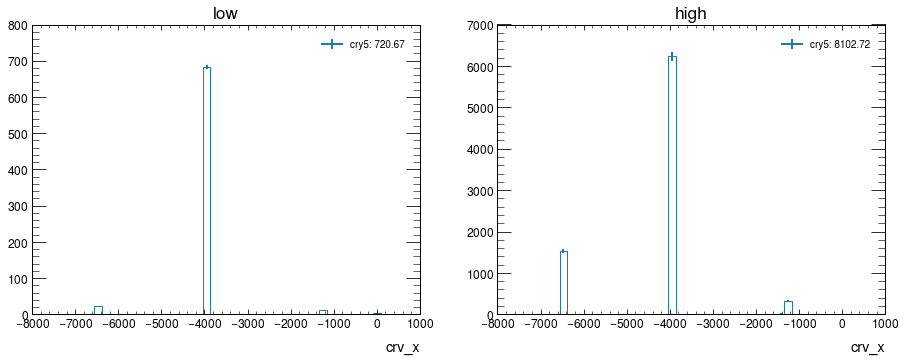

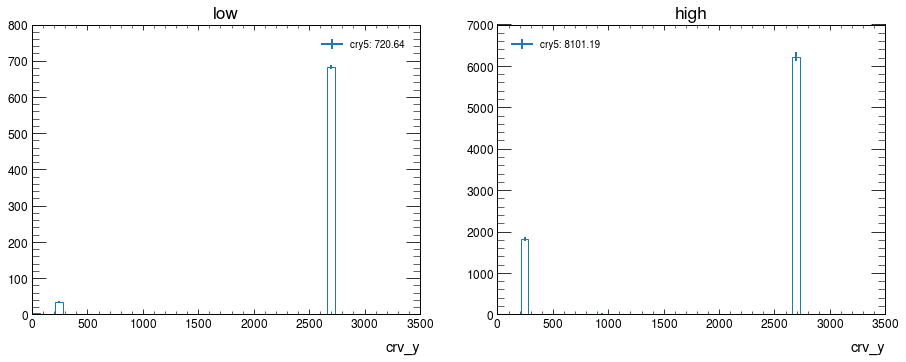

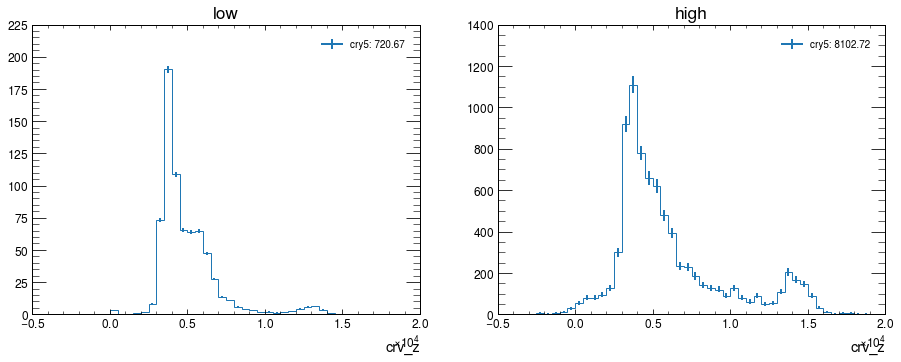

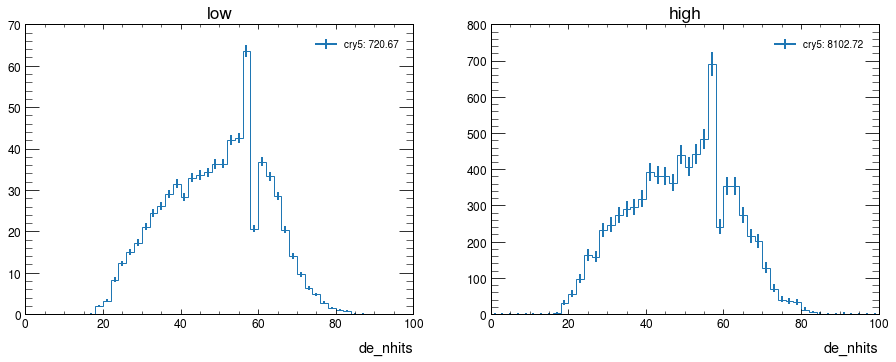

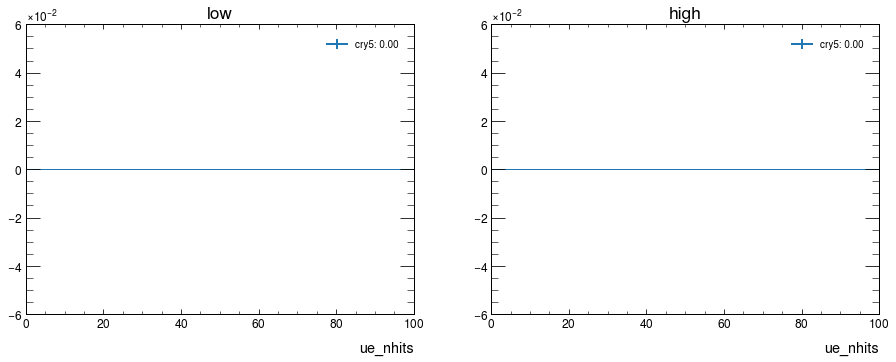

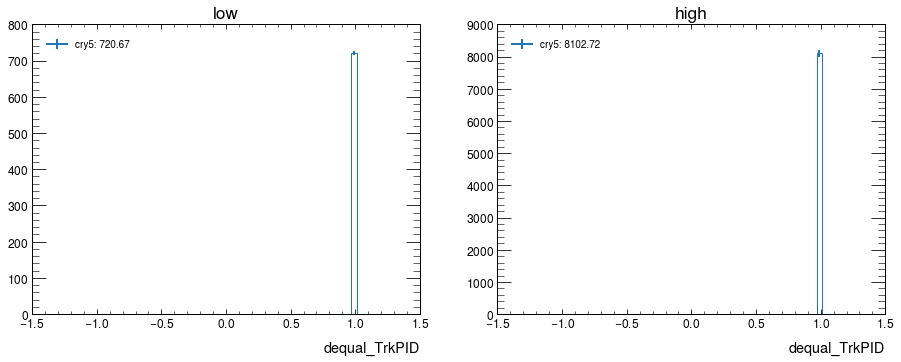

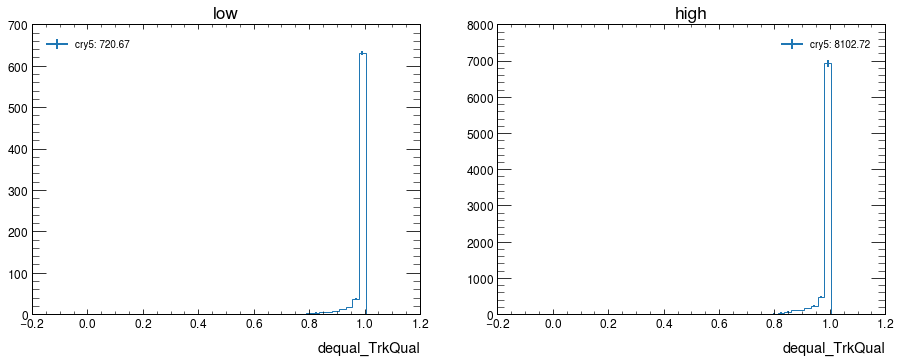

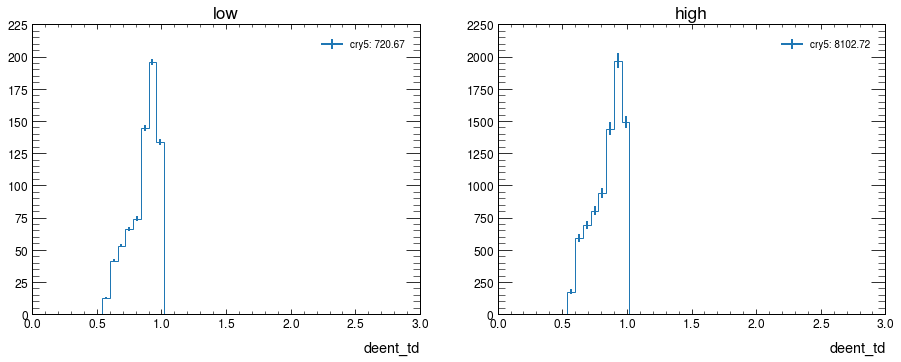

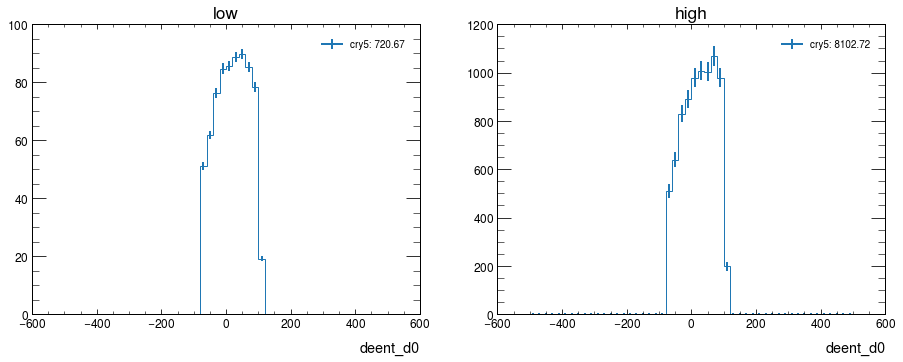

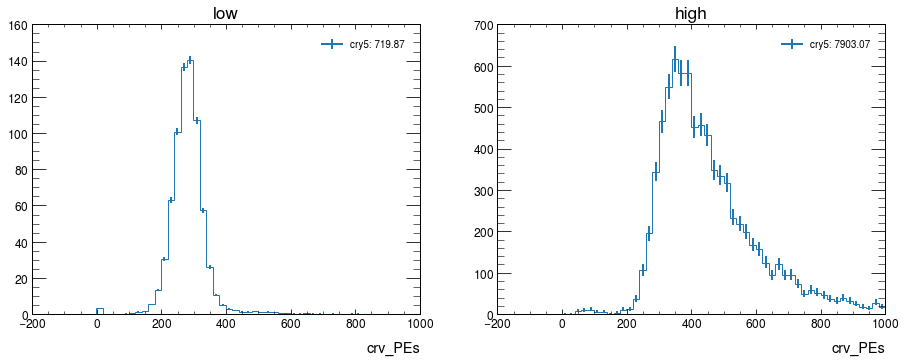

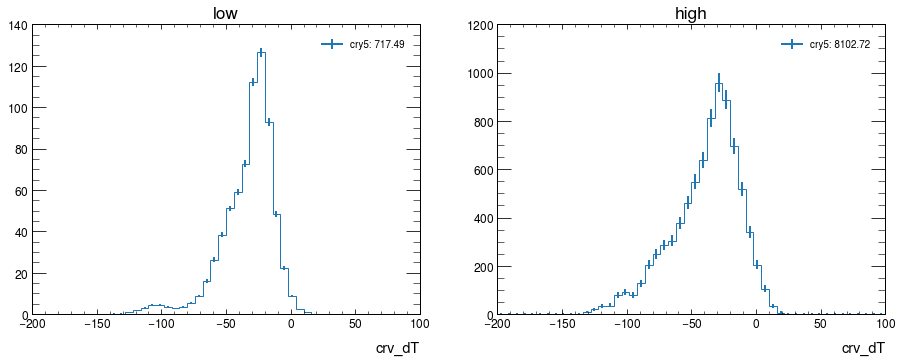

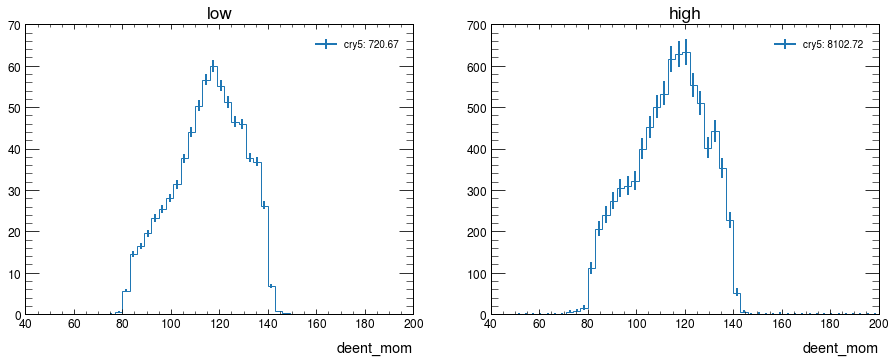

In [11]:
#np.warnings.filterwarnings('ignore')
var_dict = utils.getVarList('allCRY5')

utils.LIVETIME_LO_CRY5 = 1.15E8*780/907
utils.LIVETIME_HI_CRY5 = 3.83E6*190/323

nLTimesCRY4 = [utils.LIVETIME_LO/utils.LIVETIME_MU2E, utils.LIVETIME_HI/utils.LIVETIME_MU2E]
nLTimesCRY5 = [utils.LIVETIME_LO_CRY5/utils.LIVETIME_MU2E, utils.LIVETIME_HI_CRY5/utils.LIVETIME_MU2E]

title=["low", "high"]

for var in var_dict.keys():
  if "deent_z0" in var or "deent_om" in var: 
    continue

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
  h = hist.Hist(
    hist.axis.StrCategory(["cry4", "cry5"], name="cat"),
    hist.axis.Regular(50, var_dict[var][0], var_dict[var][1], name="x", label="w [units]"),
    hist.storage.Weight(),
  ) 

  cut_tmp=cut_nomom+'&'+cut_t0

#  cut_tmp=cut_nomom+'&'+cut_t0+'& demc_gen == 38'

  for i in [0,1]:
    h.reset()
#    h.fill(cat="cry4", x=dfCRY4.query(cut_tmp + '& is_high==%d'%i)[var].to_numpy())
    h.fill(cat="cry5", x=dfCRY5.query(cut_tmp + '& is_high==%d'%i +'& demc_gen == 38')[var].to_numpy())

#    h_tmp=(h["cry4", :] / nLTimesCRY4[i])
#    h_tmp.plot(ax=axes[i], label='cry4: %.2f'%h_tmp.counts().sum())
    h_tmp=(h["cry5", :] / nLTimesCRY5[i])
    h_tmp.plot(ax=axes[i], label='cry5: %.2f'%h_tmp.counts().sum())

    axes[i].set_xlabel(var)
    axes[i].set_title(title[i])
    axes[i].legend()
#    axes[i].set_yscale('log')


In [12]:
df = dfCRY5

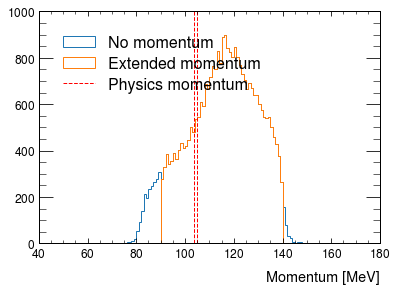

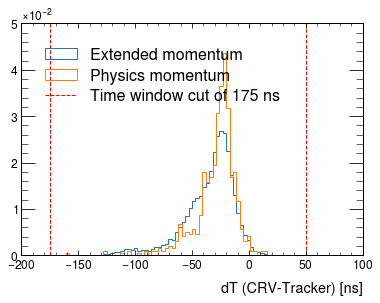

In [13]:
neve_extmom = len(df.query(cut_extmom))
neve_physmom = len(df.query(cut_phymom))
mom_scale = neve_extmom/neve_physmom
label = r'$\frac{P_{ext}}{P_{phy}} = %.1f$' % mom_scale
_, bins, _ = plt.hist(df.query(cut_nomom)['deent_mom'], bins=120, range=[50, 170], histtype='step', label='No momentum');
plt.hist(df.query(cut_extmom)['deent_mom'], bins=bins, histtype='step', label='Extended momentum');
plt.axvline(PMIN_PHY, color='r', linestyle='--', linewidth=1)
plt.axvline(PMAX_PHY, color='r', linestyle='--', label='Physics momentum', linewidth=1)
plt.legend(loc='upper left', prop={'size': 16})
plt.xlabel('Momentum [MeV]')

plt.figure()
plt.hist(df.query(cut_extmom)['crv_dT'], bins=100, range=(-200, 100), histtype='step', density=True, label='Extended momentum');
plt.hist(df.query(cut_phymom)['crv_dT'], bins=100, range=(-200, 100), histtype='step', density=True, label='Physics momentum');
plt.axvline(TMIN, color='r', linestyle='--', linewidth=1)
plt.axvline(TMAX, color='r', linestyle='--', linewidth=1, label='Time window cut of 175 ns')
plt.ylim(0)
#plt.yscale('log')
plt.xlabel('dT (CRV-Tracker) [ns]');
plt.legend(loc='upper left', prop={'size': 16})

In [14]:
def plot_background(cut_query, title, altitude_scale, log_scale=True, make_plot=True):

  lyield_scale=0.001726
  bg_ave = []
  pe_ave = []
  bg_err = []

  for ly in range(7000,17001,2000):
    bg = utils.getNormBackground(df, cut_query+" & lyield =="+str(ly), mom_scale, utils.LIVETIME_LO_CRY5, utils.LIVETIME_HI_CRY5)
    bg_ave.append(bg[0]*altitude_scale)
    pe_ave.append(ly*lyield_scale)
    bg_err.append(bg[1]*math.sqrt(altitude_scale))
    print("PE: %.1f, bg: %3.4f, err: %3.4f" % (ly*lyield_scale, bg[0]*altitude_scale, bg[1]))

  if make_plot:
    plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.k');
    plt.title(title)
  if log_scale:
    plt.yscale('log')
  return (bg_ave, pe_ave, bg_err)

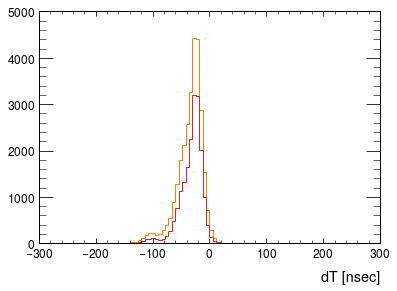

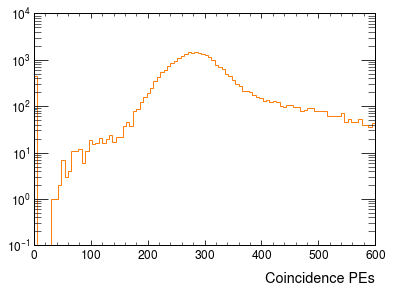

In [16]:
plt.hist(df.query(cut_current+"&"+cut_t0)['crv_dT'], range=(-300, 300), bins=100, histtype='step');
plt.hist(df.query(cut_extmom)['crv_dT'], range=(-300, 300), bins=100, histtype='step');
plt.hist(df.query(cut_nomom+'&'+cut_t0+'& demc_gen == 38 & crvsummarymc_z>-9999'+'& is_high==0')['crv_dT'], range=(-300, 300), bins=100, histtype='step', density=True);
plt.hist(df.query(cut_nomom+'&'+cut_t0+'& demc_gen == 38 & abs(demcpri_pdg)==13 & abs(crvmc_pdgId)==13 & is_high==0 & de_status==1')['crv_dT'], range=(-300, 300), bins=100, histtype='step');
plt.xlabel('dT [nsec]')

plt.figure()
plt.hist(df.query(cut_current+"&"+cut_t0)['crv_PEs'], range=(0, 600), bins=100, histtype='step');
plt.hist(df.query(cut_extmom)['crv_PEs'], range=(0, 600), bins=100, histtype='step');
plt.xlabel('Coincidence PEs')
plt.yscale('log')

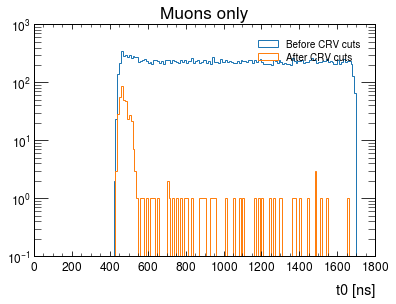

In [17]:
plt.hist(df.query(cut_extmom+" & abs(demcpri_pdg) == 13")['de_t0'], bins=170, range=(0, 1700), histtype='step', label='Before CRV cuts');
plt.hist(df.query(cut_current+" & abs(demcpri_pdg) == 13")['de_t0'], bins=170, range=(0, 1700), histtype='step', label='After CRV cuts');
plt.xlabel('t0 [ns]')
plt.title('Muons only')
plt.legend()
plt.yscale('log')

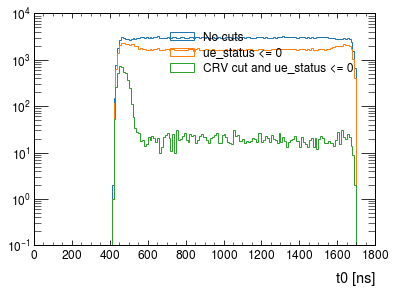

In [18]:
plt.hist(df['de_t0'], bins=170, range=(0, 1700), histtype='step', label='No cuts');
plt.hist(df.query('ue_status <= 0')['de_t0'], bins=170, range=(0, 1700), histtype='step', label='ue_status <= 0');
plt.hist(df.query('ue_status <= 0 &'+crv_time)['de_t0'], bins=170, range=(0, 1700), histtype='step', label='CRV cut and ue_status <= 0 ');
plt.xlabel('t0 [ns]')
plt.legend(prop={'size': 12});
plt.yscale('log')

In [19]:
h = hist.Hist(
  hist.axis.StrCategory(["all", "cut", "all", "cut"], name="cat"),
  hist.axis.Regular(10, 400, 1800, name="x", label="t0 [ns]"),
  hist.storage.Weight(),
) 

cut_tmp='ue_status <= 0 & crvsummarymc_z>-9999 & abs(demcpri_pdg) == 13'
h.fill(cat="all", x=dfCRY5.query(cut_tbox+'&' + cut_tmp + '& is_high==0')['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_LO_CRY5)
h.fill(cat="all", x=dfCRY5.query(cut_tbox+'&' + cut_tmp + '& is_high==1')['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_HI_CRY5)
cut_tmp = cut_tmp +'&'+crv_time
h.fill(cat="cut", x=dfCRY5.query(cut_tbox+'&' + cut_tmp + '& is_high==0')['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_LO_CRY5);
h.fill(cat="cut", x=dfCRY5.query(cut_tbox+'&' + cut_tmp + '& is_high==1')['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_HI_CRY5);

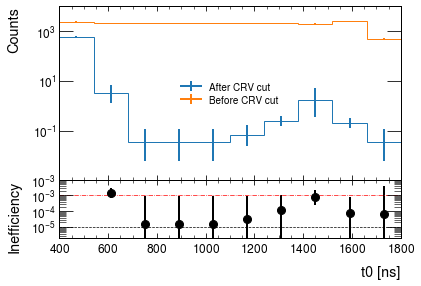

In [20]:
import matplotlib.ticker

fig = plt.figure()
h["cut", :].plot_ratio(h["all", :], rp_num_label="After CRV cut", rp_denom_label="Before CRV cut", rp_ylim=[0.000002, 0.009], rp_uncert_draw_type='line');
fig.get_axes()[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
fig.get_axes()[1].set_ylabel('Inefficiency')
fig.get_axes()[1].set_yscale('log')
fig.get_axes()[0].set_yscale('log')
fig.get_axes()[1].axhline(0.00001,color='black',ls='--', linewidth=0.7)
fig.get_axes()[1].axhline(0.001,color='red',ls='-.', linewidth=0.7)

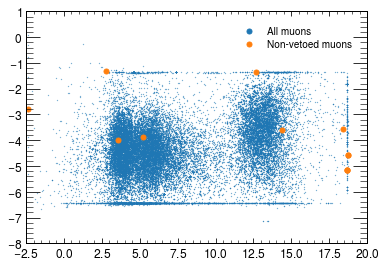

In [21]:
cut_tmp=cut_tbox+'& ue_status <= 0 & abs(demcpri_pdg) == 13 & crvsummarymc_z>-9999 &'+cut_t0
plt.plot(dfCRY5.query(cut_tmp)['crvsummarymc_z']/1000, dfCRY5.query(cut_tmp)['crvsummarymc_x']/1000, '.', label='All muons', markersize=0.5)
cut_tmp=cut_tmp+'& crv_PEs==0'
plt.plot(dfCRY5.query(cut_tmp)['crvsummarymc_z']/1000, dfCRY5.query(cut_tmp)['crvsummarymc_x']/1000, '.', label='Non-vetoed muons', markersize=10)
plt.legend();
lgnd = plt.legend()
lgnd.legendHandles[0].set_markersize(10)

PE: 12.1, bg: 0.0000, err: 0.0000
PE: 15.5, bg: 0.0000, err: 0.0000
PE: 19.0, bg: 0.0000, err: 0.0000
PE: 22.4, bg: 0.0000, err: 0.0000
PE: 25.9, bg: 0.0000, err: 0.0000
PE: 29.3, bg: 0.0316, err: 0.0049
PE: 12.1, bg: 0.0000, err: 0.0000
PE: 15.5, bg: 0.0000, err: 0.0000
PE: 19.0, bg: 0.0000, err: 0.0000
PE: 22.4, bg: 0.0000, err: 0.0000
PE: 25.9, bg: 0.0000, err: 0.0000
PE: 29.3, bg: 0.0456, err: 0.0055
PE: 12.1, bg: 0.0000, err: 0.0000
PE: 15.5, bg: 0.0000, err: 0.0000
PE: 19.0, bg: 0.0000, err: 0.0000
PE: 22.4, bg: 0.0000, err: 0.0000
PE: 25.9, bg: 0.0000, err: 0.0000
PE: 29.3, bg: 0.0017, err: 0.0011


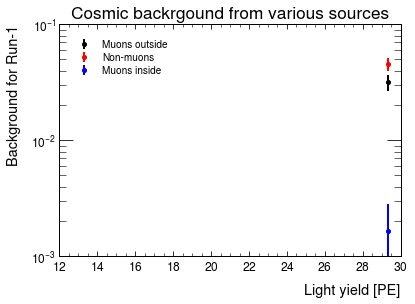

In [22]:
title='Muons outside'
bg_ave, pe_ave, bg_err = plot_background(cut_current+"& "+cut_t0+" & abs(demcpri_pdg) == 13", title, 1.05, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.k', label=title)

title = 'Non-muons'
bg_ave, pe_ave, bg_err = plot_background(cut_current+"& "+cut_t0+" & abs(demcpri_pdg) != 13", title, 1.2, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.r', label=title)

title='Muons inside'
bg_ave, pe_ave, bg_err = plot_background(cut_current+"& "+cut_t0+" & abs(demcpri_pdg) == 13 & crvsummarymc_z>-9999", title, 1.05, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.b', label=title)

plt.yscale('log');
plt.title('Cosmic backrgound from various sources');
plt.xlabel('Light yield [PE]')
plt.ylabel('Background for Run-1');
plt.legend()

In [23]:
print("Efficiency: %2.2e"%(0.0058/248.5517))

Efficiency: 2.33e-05


PE: 12.1, bg: 0.0000, err: 0.0000
PE: 15.5, bg: 0.0000, err: 0.0000
PE: 19.0, bg: 0.0000, err: 0.0000
PE: 22.4, bg: 0.0000, err: 0.0000
PE: 25.9, bg: 0.0000, err: 0.0000
PE: 29.3, bg: 181.6722, err: 2.4088


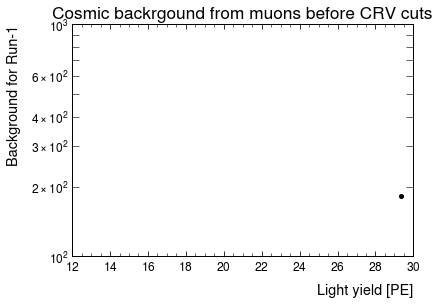

In [24]:
title='Muons'
bg_ave, pe_ave, bg_err = plot_background(cut_extmom+"& "+cut_t0+" & abs(demcpri_pdg) == 13", title, 1.0, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.k', label=title)

plt.yscale('log');
plt.title('Cosmic backrgound from muons before CRV cuts');
plt.xlabel('Light yield [PE]')
plt.ylabel('Background for Run-1');

Text(0.5, 1.0, 'Background sources after kin and CRV cuts')

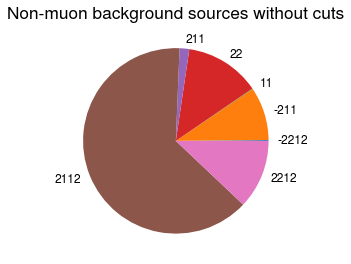

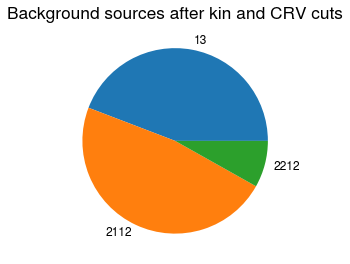

In [25]:
df.query('abs(demcpri_pdg) != 13').groupby(['demcpri_pdg']).size().plot(kind='pie', y='demcpri_pdg')
plt.ylabel('')
plt.title('Non-muon background sources without cuts')
plt.figure()
df.query(cut_current+"& "+cut_t0).groupby(['demcpri_pdg']).size().plot(kind='pie', y='demcpri_pdg', )
plt.ylabel("")
plt.title('Background sources after kin and CRV cuts')

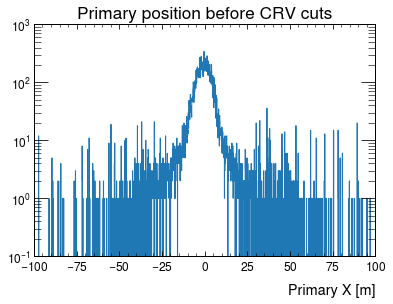

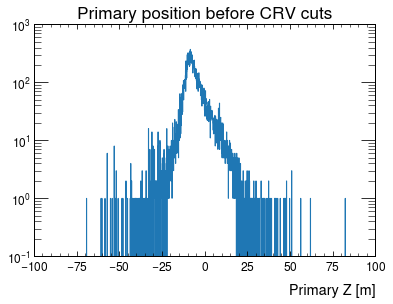

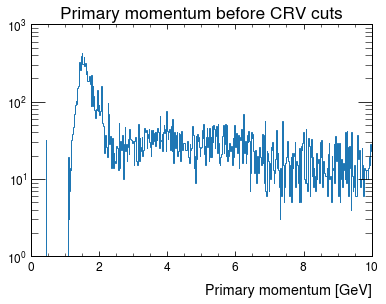

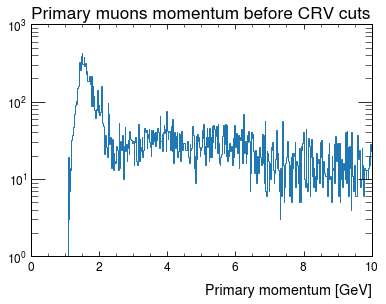

In [26]:
plt.hist(df.query(cut_extmom+"& "+cut_t0)['demcpri_posX']/1000, range=(-100, 100), bins=2000, histtype='step');
plt.yscale('log')
plt.title('Primary position before CRV cuts')
plt.xlabel('Primary X [m]')
plt.figure()
plt.hist(df.query(cut_extmom+"& "+cut_t0)['demcpri_posZ']/1000, range=(-100, 100), bins=2000, histtype='step');
plt.title('Primary position before CRV cuts')
plt.xlabel('Primary Z [m]')
plt.yscale('log')

plt.figure()
plt.hist(df.query(cut_extmom+"& "+cut_t0)['demcpri_mom']/1000, range=(0, 10), bins=500, histtype='step');
plt.title('Primary momentum before CRV cuts')
plt.xlabel('Primary momentum [GeV]')
plt.yscale('log')

plt.figure()
plt.hist(df.query(cut_extmom+"& abs(demcpri_pdg) == 13 &"+cut_t0)['demcpri_mom']/1000, range=(0, 10), bins=500, histtype='step');
plt.title('Primary muons momentum before CRV cuts')
plt.xlabel('Primary momentum [GeV]')
plt.yscale('log')

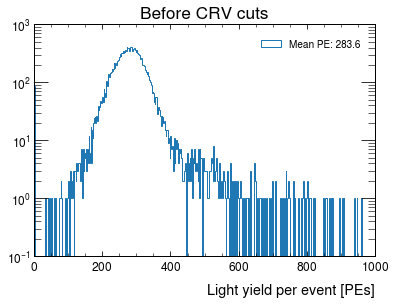

In [27]:
plt.figure()
label='Mean PE: %.1f'%(df.query(cut_extmom+" & is_high==0 & "+cut_t0)['crv_PEs'].mean())
plt.hist(df.query(cut_extmom+"& is_high==0 &"+cut_t0)['crv_PEs'], range=(0, 1000), bins=500, histtype='step', label=label);
plt.title('Before CRV cuts')
plt.xlabel('Light yield per event [PEs]')
plt.legend()
plt.yscale('log')

In [28]:
# Rare event induced by 0.5 GeV gamma
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
df.query(cut_extmom+"& abs(demcpri_pdg) != 13 & demcpri_mom<1000 &"+cut_t0)[['demcpri_mom', 'demcpri_pdg', 'crv_PEs']]

,demcpri_mom,demcpri_pdg,crv_PEs
1395,451.248169,22,219
1397,451.248169,22,228
2352,451.248169,22,267
24990,451.248169,22,252
29448,451.248169,22,224
46741,451.248169,22,216
46743,451.248169,22,274
47701,451.248169,22,212
74698,451.248169,22,215
74874,451.248169,22,219


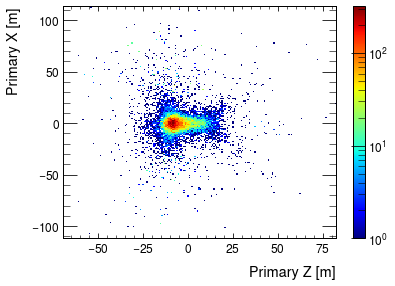

In [29]:
h=plt.hist2d(df.query(cut_extmom)['demcpri_posZ']/1000, df.query(cut_extmom)['demcpri_posX']/1000, bins = 200, norm=mpl.colors.LogNorm(), cmap=plt.cm.jet);
plt.colorbar(h[3])
plt.xlabel('Primary Z [m]')
plt.ylabel('Primary X [m]');

#Calo variables

(0.0, 4.0)

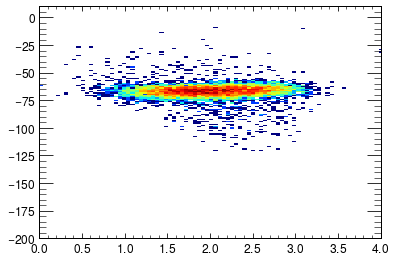

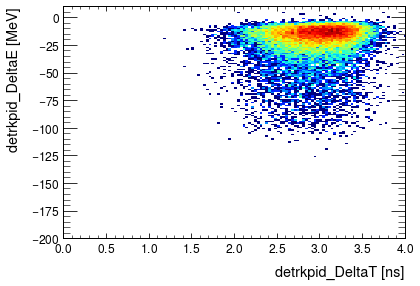

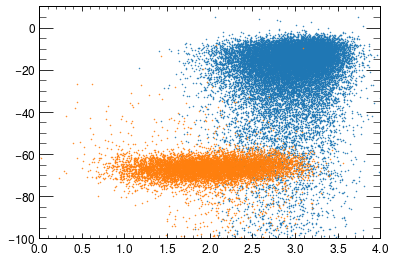

In [30]:
from matplotlib.patches import Rectangle

cuts = cut_extmom+'& abs(demc_pdg) == 13'
h=plt.hist2d(df.query(cuts)['detrkpid_DeltaT'], df.query(cuts)['detrkpid_DeltaE'], bins = 100, norm=mpl.colors.LogNorm(), cmap=plt.cm.jet);
plt.xlim(0,4)
plt.ylim(-200,10)
#currentAxis = plt.gca()
#currentAxis.add_patch(Rectangle((-3, -60), 3, 60, fill=None, alpha=1, color='red'))

plt.figure()
cuts = cut_extmom+'& abs(demc_pdg) == 11'
h=plt.hist2d(df.query(cuts)['detrkpid_DeltaT'], df.query(cuts)['detrkpid_DeltaE'], bins = 100, norm=mpl.colors.LogNorm(), cmap=plt.cm.jet);
plt.xlabel('detrkpid_DeltaT [ns]')
plt.ylabel('detrkpid_DeltaE [MeV]')
plt.xlim(0,4)
plt.ylim(-200,10)
#currentAxis = plt.gca()
#currentAxis.add_patch(Rectangle((-3, -60), 3, 60, fill=None, alpha=1, color='red'))


plt.figure()
plt.plot(df.query(cut_extmom+'& abs(demc_pdg) == 11')['detrkpid_DeltaT'], df.query(cut_extmom+'& abs(demc_pdg) == 11')['detrkpid_DeltaE'], '.', markersize=1.0);
plt.plot(df.query(cut_extmom+'& abs(demc_pdg) == 13')['detrkpid_DeltaT'], df.query(cut_extmom+'& abs(demc_pdg) == 13')['detrkpid_DeltaE'], '.', markersize=1.0);
plt.ylim(-100, 10)
plt.xlim(0, 4)


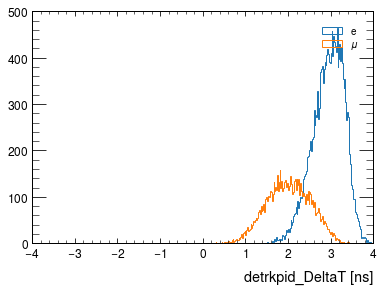

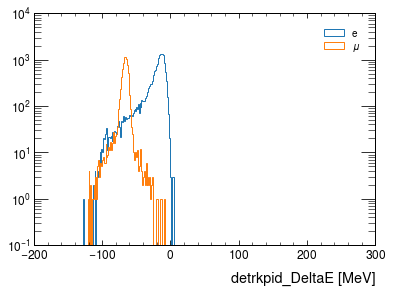

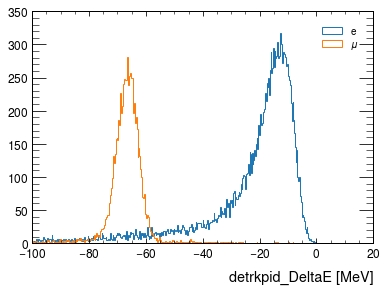

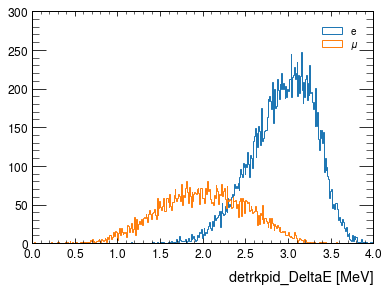

In [31]:
plt.figure()
plt.hist(df.query(cut_extmom+'& abs(demc_pdg) == 11')['detrkpid_DeltaT'], bins = 400, range=(-4,4), histtype='step', label='e');
plt.hist(df.query(cut_extmom+'& abs(demc_pdg) == 13')['detrkpid_DeltaT'], bins = 400, range=(-4,4), histtype='step', label='$\mu$');
plt.xlabel('detrkpid_DeltaT [ns]')
#plt.yscale('log')
plt.legend()

plt.figure()
plt.hist(df.query(cut_extmom+'& abs(demc_pdg) == 11 ')['detrkpid_DeltaE'], bins = 400, range=(-200,300), histtype='step', label='e');
plt.hist(df.query(cut_extmom+'& abs(demc_pdg) == 13 ')['detrkpid_DeltaE'], bins = 400, range=(-200,300), histtype='step', label='$\mu$');
plt.xlabel('detrkpid_DeltaE [MeV]')
plt.yscale('log')
plt.legend()

plt.figure()
plt.hist(df.query(cut_extmom+'& abs(demc_pdg) == 11 & detrkpid_DeltaE<0')['detrkpid_DeltaE'], bins = 400, range=(-100,10), histtype='step', label='e');
plt.hist(df.query(cut_extmom+'& abs(demc_pdg) == 13 & detrkpid_DeltaE<0')['detrkpid_DeltaE'], bins = 400, range=(-100,10), histtype='step', label='$\mu$');
plt.xlabel('detrkpid_DeltaE [MeV]')
#plt.yscale('log')
plt.legend()

plt.figure()
plt.hist(df.query(cut_extmom+'& abs(demc_pdg) == 11 & detrkpid_DeltaE<0')['detrkpid_DeltaT'], bins = 400, range=(0,4), histtype='step', label='e');
plt.hist(df.query(cut_extmom+'& abs(demc_pdg) == 13 & detrkpid_DeltaE<0')['detrkpid_DeltaT'], bins = 400, range=(0,4), histtype='step', label='$\mu$');
plt.xlabel('detrkpid_DeltaE [MeV]')
#plt.yscale('log')
plt.legend()